<a href="https://colab.research.google.com/github/julurisaichandu/responsible-ai/blob/main/fairness_evaluation_german_credit_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Responsible AI - Project

This project aims to build a Logistic Regression model to predict the credit risk (i.e., whether an individual is a credit risk or not) using the [German Credit Dataset](https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29).


__Problem Definition:__
Given a set of features about an individual (e.g. age, past credit history, immigration status, ...), the aim is to predict whether a loan is repaid or not (is customer a credit risk). We impose the additional constraint that the model should be fair with respect to different age groups ($\geq$ 25 yrs and $<$ 25 yrs). Description of the clear goal initally is required for any fairness exploration task.

In the banking industry, there are certain regulations regarding the use of sensitive features (e.g., age, ethnicity, marital status, ...). According to those regulations, it would not be okay if age played a significant role in the model (loans should be approved/denied regardless of an individuals' age).

For example, certain laws declare it unlawful for creditors to discriminate against any applicant on the basis of age (or other sensitive attributes). For more details, have a look at this paper:

```
F. Kamiran and T. Calders, "Data Preprocessing Techniques for Classification without Discrimination," Knowledge and Information Systems, 2012
```

__Table of contents__

1. Initial Steps
    * Exploratory Data Analysis
    * Select features to build the model
    * Train - Validation Datasets
2. Evaluating logistic regression model without any fariness processing
    * Data Processing with Pipeline
    * Train a Logistic Regression Classifier
    * Make Predictions on the Test Dataset
    * Evaluating Disparate Impact on Test Data
    * Accuracy & F1 Score
    * SHAP
3. Testing and Mitigating Disparate Impact with IBM AI Fairness 360
    * Pre processing traning data for analyzing it using AIF360
    * Creating a BinaryLabelDataset and checking the DI value of the training dataset without DI removal
    * Removing DI usig AIF360 DisparateImpactRemover
    * visualization for checking the affect of DI removal on credit_amount
    * Train a Logistic Regression Classifier on DI removed dataset
    * Applying DI removal for the test set
    * Make Predictions on the Test Dataset
    * Evaluating Disparate Impact on Test Data
    * Accuracy & F1 Score
4. Reweighing - Pre processing technique
    * Train a Classifier using reiweighied traning data
    * Make Predictions on the Test Dataset
    * Evaluating Disparate Impact on Test Data
    * Accuracy & F1 Score
5. Equlaized odds using fairlearn- post processing technique
    * Setting up ThresholdOptimizer for equalized odds
    * Make predicitons on test dataset using EO
    * Pipeline for predicting without applying equalized odds
    * Training Logistic regression without equalized odds for comparision
    * Find predictions with and without equalized odds
    * Plot for comparing the test data predicitons with and without applying EO
    * Evaluating Disparate Impact on Test Data
    * Accuracy & F1 Score
6. Final evaluation of different fairness techniques

*Datasets and files*


- ```german_credit_training.csv```: Training data with features, credit history, dependents, savings, account status, age group (and more). The label is __credit_risk__.

- ```german_credit_test.csv```: Test data with same features as above apart from label.

In [ ]:
# basic libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency
# Fairness libraries
from folktables.acs import *
from folktables.folktables import *
from folktables.load_acs import *
from aif360.datasets import BinaryLabelDataset, Dataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover

from fairlearn.reductions import EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame, selection_rate

import shap
# Jupyter(lab) libraries
import warnings
from sklearn import set_config

warnings.filterwarnings("ignore")

In [ ]:
# ! pip install --upgrade shap numba
# ! pip install --upgrade matplotlib
# ! pip install aif360 -q
# ! pip install BlackBoxAuditing -q
# ! pip install fairlearn -q

In [ ]:
# dictionary for storing metrics after applying different fairness metrics
dict_metrics = {}
dict_metrics["no_preprocessing"]={"di":"", "accuracy":"", "f1":""}
dict_metrics["di_removed_preprocessing"]={"di":"", "accuracy":"", "f1":""}
dict_metrics["reweighing_preprocessing"]={"di":"", "accuracy":"", "f1":""}
dict_metrics["equalized_odds_preprocessing"]={"di":"", "accuracy":"", "f1":""}
dict_metrics

{'no_preprocessing': {'di': '', 'accuracy': '', 'f1': ''},
 'di_removed_preprocessing': {'di': '', 'accuracy': '', 'f1': ''},
 'reweighing_preprocessing': {'di': '', 'accuracy': '', 'f1': ''},
 'equalized_odds_preprocessing': {'di': '', 'accuracy': '', 'f1': ''}}

# Initial Steps

## Read the datasets

In [ ]:
# reading the training and test datasets into dataframes
training_data = pd.read_csv("data/german_credit_training.csv")
test_data = pd.read_csv("data/german_credit_test.csv")

print("The shape of the training dataset is:", training_data.shape)
print("The shape of the test dataset is:", test_data.shape)

The shape of the training dataset is: (800, 24)
The shape of the test dataset is: (200, 23)


## Exploratory Data Analysis
We look at number of rows, columns, and some simple statistics of the dataset.

In [ ]:
training_data.head()

,ID,sex,personal_status,checking_account_status,credit_duration_months,credit_history,credit_purpose,credit_amount,savings,employed_since_years,...,age_years,other_installment_plans,housing,num_existing_credits,job_status,num_people_liable_for,telephone,foreign_worker,credit_risk,age_groups
0,564,male,married/widowed,... < 0 DM,24,existing credits paid back duly till now,retraining,4712,.. >= 1000 DM,1 <= ... < 4 years,...,37,bank,rent,2-3,management/self-employed/highly qualified empl...,0 to 2,True,False,0,1
1,484,male,married/widowed,... >= 200 DM,12,all credits at this bank paid back duly,others,1163,100 <= ... < 500 DM,1 <= ... < 4 years,...,44,none,rent,1,skilled employee/official,0 to 2,True,False,0,1
2,26,female,single,... >= 200 DM,6,delay in paying off in the past,furniture/equipment,426,unknown/no savings account,.. >= 7 years,...,39,none,rent,1,unskilled - resident,0 to 2,False,False,0,1
3,443,male,married/widowed,... >= 200 DM,12,no credits taken/all credits paid back duly,repairs,719,unknown/no savings account,.. >= 7 years,...,41,bank,rent,1,unskilled - resident,3 or more,False,False,1,1
4,211,female/male,female (non-single) or male (single),... >= 200 DM,36,no credits taken/all credits paid back duly,furniture/equipment,3835,.. >= 1000 DM,.. >= 7 years,...,45,none,rent,1,unskilled - resident,0 to 2,True,False,0,1


In [ ]:
test_data.head()

,ID,sex,personal_status,checking_account_status,credit_duration_months,credit_history,credit_purpose,credit_amount,savings,employed_since_years,...,property,age_years,other_installment_plans,housing,num_existing_credits,job_status,num_people_liable_for,telephone,foreign_worker,age_groups
0,963,male,married/widowed,... >= 200 DM,24,no credits taken/all credits paid back duly,furniture/equipment,2397,100 <= ... < 500 DM,.. >= 7 years,...,building society savings agreement/life insurance,35,bank,rent,2-3,skilled employee/official,0 to 2,True,False,1
1,611,female/male,female (non-single) or male (single),0 <= ... < 200 DM,10,no credits taken/all credits paid back duly,others,1240,... < 100 DM,.. >= 7 years,...,real estate,48,none,own,1,unskilled - resident,3 or more,False,False,1
2,106,male,married/widowed,... >= 200 DM,18,critical account/other credits existing (not a...,others,6458,unknown/no savings account,.. >= 7 years,...,real estate,39,bank,rent,2-3,management/self-employed/highly qualified empl...,3 or more,True,False,1
3,891,male,married/widowed,... >= 200 DM,15,all credits at this bank paid back duly,furniture/equipment,1829,unknown/no savings account,.. >= 7 years,...,building society savings agreement/life insurance,46,none,rent,2-3,skilled employee/official,0 to 2,True,False,1
4,342,female,single,... < 0 DM,18,no credits taken/all credits paid back duly,furniture/equipment,3213,100 <= ... < 500 DM,... < 1 year,...,unknown/no property,25,none,for free,1,skilled employee/official,0 to 2,False,False,1


In [ ]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        800 non-null    int64 
 1   sex                       800 non-null    object
 2   personal_status           800 non-null    object
 3   checking_account_status   800 non-null    object
 4   credit_duration_months    800 non-null    int64 
 5   credit_history            800 non-null    object
 6   credit_purpose            800 non-null    object
 7   credit_amount             800 non-null    int64 
 8   savings                   800 non-null    object
 9   employed_since_years      800 non-null    object
 10  installment_rate          800 non-null    object
 11  other_debtors_guarantors  800 non-null    object
 12  present_residence_since   800 non-null    object
 13  property                  800 non-null    object
 14  age_years                 

In [ ]:
# correlation_matrix = training_data.corr()
# sns.heatmap(correlation_matrix, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()

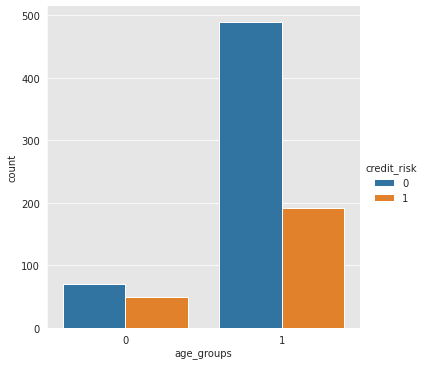

In [ ]:
sns.catplot(x="age_groups", hue="credit_risk", kind="count", data=training_data)

- We observe that age group with members that are less than 25 yrs old are at a disadvantage. Almost the same number of applications get rejected as approved whereas for the group with members $\geq$ the ration is almost 3:1 (e.g. three times as many applications approved as rejected).

Below Visualizing the proportion of individuals classified as a credit risk within each age group. This will help us identify if one group is more adversely affected than the other.

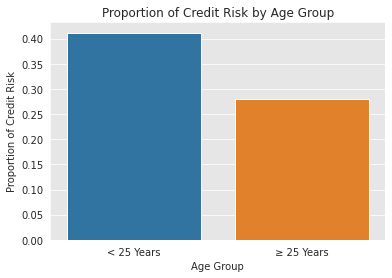

In [ ]:
age_risk = training_data.groupby('age_groups')['credit_risk'].mean().reset_index()
sns.barplot(data=age_risk, x='age_groups', y='credit_risk')
plt.title('Proportion of Credit Risk by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Proportion of Credit Risk')
plt.xticks(ticks=[0, 1], labels=['< 25 Years', '≥ 25 Years'])
plt.show()

- we can see that the users under 25 have a more proportion of them termed as they are at credit risk

In [ ]:
contingency_table = pd.crosstab(training_data['age_groups'], training_data['credit_risk'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi2: {chi2}, p-value: {p}")

Chi2: 7.701876639055032, p-value: 0.005516344269642404


**p-value (0.0055)**: Since the p-value is <0.05, there is a significant association between age groups and credit risk, meaning credit risk varies by age group (<25 or ≥25 years).

**Chi-squared (7.70)**: This indicates a moderate association between the two variables.

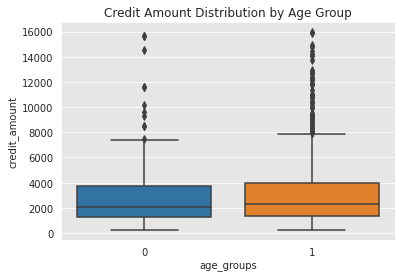

In [ ]:
sns.boxplot(data=training_data, x='age_groups', y='credit_amount')
plt.title('Credit Amount Distribution by Age Group')
plt.show()

The box plot shows a noticeable difference in credit amounts between the two age groups. Age group 1.0 generally has higher credit amounts than age group 0.0. This is visible in the higher position of the orange box compared to the blue box. The median line for age group 1.0 is also higher, and its upper whisker and outliers reach higher values. While there's still overlap between the two groups, age group 1.0 consistently shows higher credit amounts across different parts of the distribution. This gap suggests that age may have some influence on credit amounts, with the older group


## Select features to build the model

In [ ]:
# Grab model features/inputs and target/output
categorical_features = (
    training_data.drop("credit_risk", axis=1)
    .select_dtypes(include="object")
    .columns.tolist()
)
print("Categorical columns:", categorical_features)

print("")

numerical_features = (
    training_data.drop("credit_risk", axis=1)
    .select_dtypes(include=np.number)
    .columns.tolist()
)
print("Numerical columns:", numerical_features)

Categorical columns: ['sex', 'personal_status', 'checking_account_status', 'credit_history', 'credit_purpose', 'savings', 'employed_since_years', 'installment_rate', 'other_debtors_guarantors', 'present_residence_since', 'property', 'other_installment_plans', 'housing', 'num_existing_credits', 'job_status', 'num_people_liable_for']

Numerical columns: ['ID', 'credit_duration_months', 'credit_amount', 'age_years', 'age_groups']


Separate features and the model target.

In [ ]:
model_target = "credit_risk"
model_features = categorical_features + numerical_features

print("Model features: ", model_features)
print("Model target: ", model_target)

Model features:  ['sex', 'personal_status', 'checking_account_status', 'credit_history', 'credit_purpose', 'savings', 'employed_since_years', 'installment_rate', 'other_debtors_guarantors', 'present_residence_since', 'property', 'other_installment_plans', 'housing', 'num_existing_credits', 'job_status', 'num_people_liable_for', 'ID', 'credit_duration_months', 'credit_amount', 'age_years', 'age_groups']
Model target:  credit_risk


In [ ]:
to_remove = "ID"

# Drop 'ID' feature from the respective list(s)
if to_remove in model_features:
    model_features.remove(to_remove)
if to_remove in categorical_features:
    categorical_features.remove(to_remove)
if to_remove in numerical_features:
    numerical_features.remove(to_remove)

Let's also remove `age_years` as this is an proxy for the age groups.

In [ ]:
to_remove = "age_years"

# Drop 'ID' feature from the respective list(s)
if to_remove in model_features:
    model_features.remove(to_remove)
if to_remove in categorical_features:
    categorical_features.remove(to_remove)
if to_remove in numerical_features:
    numerical_features.remove(to_remove)

## Train - Validation Datasets

In [ ]:
# We only need to split between train and val (test is already separate)
train_data, val_data = train_test_split(
    training_data, test_size=0.1, shuffle=True, random_state=23
)

# Print the shapes of the Train - Test Datasets
print(
    "Train - Test - Validation datasets shapes: ",
    train_data.shape,
    test_data.shape,
    val_data.shape,
)
train_data.reset_index(inplace=True, drop=True)
val_data.reset_index(inplace=True, drop=True)

Train - Test - Validation datasets shapes:  (720, 24) (200, 23) (80, 24)


# Evaluating logistic regression model without any fariness processing

## Data processing with Pipeline


Build a pipeline to impute the missing values and scale the numerical features, and finally train a LogisticRegression on the imputed and scaled dataset. Remember we have not yet introduced any data pre processing methods related to fairness.


In [ ]:
# Preprocess the numerical features
numerical_processor = Pipeline(
    [("num_imputer", SimpleImputer(strategy="mean")), ("num_scaler", MinMaxScaler())]
)
# Preprocess the categorical features
categorical_processor = Pipeline(
    [
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("cat_encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine all data preprocessors from above
data_processor = ColumnTransformer(
    [
        ("numerical_processing", numerical_processor, numerical_features),
        ("categorical_processing", categorical_processor, categorical_features),
    ]
)


# Pipeline with data transforms, along with an estimator at the end
pipeline = Pipeline(
    [
        ("data_processing", data_processor),
        ("lg", LogisticRegression(solver="lbfgs", penalty="none")),
    ]
)

set_config(display="diagram")
pipeline

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['credit_duration_months',
                                                   'credit_amount',
                                                   'age_groups']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_en...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'personal_status',
                                                   'checking_account_status',
                                                   'credit_history',
                                                   'credit_purpose', 'savings',
                                                   'employed_since_years',
                                                   'installment_rate',
                                                   'other_debtors_guarantors',
                                                   'present_residence_since',
                                                   'property',
                                                   'other_installment_plans',
                                                   'housing',
                                                   'num_existing_credits',
                                                   'job_status',
                                                   'num_people_liable_for'])])),
                ('lg', LogisticRegression(penalty='none'))])

## Train a Logistic Regression Classifier


In [ ]:
# Get train data to train the classifier
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the classifier to the train data
# Train data going through the Pipeline is imputed (with means from the train data),
#   scaled (with the min/max from the train data),
#   and finally used to fit the model
pipeline.fit(X_train, y_train)
print('trained pipeline')

trained pipeline


## Make Predictions on the Test Dataset
Use the trained classifier to predict the labels on the test set.

In [ ]:
# Get test data to validate the classifier
X_test = test_data[model_features]

# Use the fitted model to make predictions on the test dataset
# Test data going through the Pipeline is imputed (with means from the train data),
#   scaled (with the min/max from the train data),
#   and finally used to make predictions
test_predictions = pipeline.predict(X_test)

In [ ]:
# writing predictions into a file
result_df = pd.DataFrame(columns=["ID", "credit_risk_pred"])
result_df["ID"] = test_data["ID"].tolist()
result_df["credit_risk_pred"] = test_predictions

result_df.to_csv("data/testing_results_without_fairness.csv", index=False)

## Evaluating Disparate Impact on Test Data
To evaluate the fairness of the model predictions, we will calculate the disparate impact (DI) metric

In [ ]:
def calculate_di(test_data, pred_df, pred_col="credit_risk_pred"):
    """
    Function to calculate Disparate Impact metric using the results from this notebook.
    """
    try:
        # Merge predictions with original test data to model per group
        di_df = pred_df.merge(test_data, on="ID")
        # Count for group with members less than 25y old
        pos_outcomes_less25 = di_df[di_df["age_groups"] == 0][pred_col].value_counts()[
            0
        ]  # value_counts()[0] takes the count of the '0 credit risk' == 'not credit risk'
        total_less25 = len(di_df[di_df["age_groups"] == 0])
        # Count for group with members greater equal 25y old
        pos_outcomes_geq25 = di_df[di_df["age_groups"] == 1][pred_col].value_counts()[
            0
        ]  # value_counts()[0] takes the count of the '0 credit risk' == 'not credit risk'
        total_geq25 = len(di_df[di_df["age_groups"] == 1])
        # Check if correct number of gorups
        if total_geq25 == 0:
            print("There is only one group present in the data.")
        elif total_less25 == 0:
            print("There is only one group present in the data.")
        else:
            disparate_impact = (pos_outcomes_less25 / total_less25) / (
                pos_outcomes_geq25 / total_geq25
            )
            return disparate_impact
    except:
        print("Wrong inputs provided.")

In [ ]:
di = calculate_di(test_data, result_df, "credit_risk_pred")
dict_metrics["no_preprocessing"]["di"] = di

## Accuracy & F1 Score

In [ ]:
acc_score = accuracy_score(
    pd.read_csv("data/german_credit_test_labels.csv")[
        "credit_risk"
    ],
    result_df["credit_risk_pred"],
)
dict_metrics['no_preprocessing']["accuracy"]=acc_score
acc_score

0.785

In [ ]:
f1 = f1_score(
    pd.read_csv("data/german_credit_test_labels.csv")[
        "credit_risk"
    ],
    result_df["credit_risk_pred"],
)
dict_metrics['no_preprocessing']["f1"]=f1
f1

0.6194690265486726

# SHAP

We use SHAP (SHapley Additive exPlanations) values to interpret the model's predictions and understand the contribution of individual features, particularly focusing on sensitive attributes such as age_groups. SHAP provides a unified measure of feature importance, allowing us to visualize how different features impact the likelihood of a positive outcome in our credit risk model. By employing various SHAP visualizations, including force plots and beeswarm plots, we gain insights into the relationships between features and their effects on predictions, thereby promoting transparency and fairness in the model's decision-making process.

In [ ]:
ft_names = numerical_features + cat_ft_names
# print(X_train.head())

X_sample = pd.DataFrame(
    pipeline[0].transform(train_data[:]).toarray(), columns=ft_names
)


# Create a SHAP LinearExplainer
explainer = shap.LinearExplainer(pipeline[-1], X_sample)

# Generate SHAP values
shap_values = explainer(X_sample)

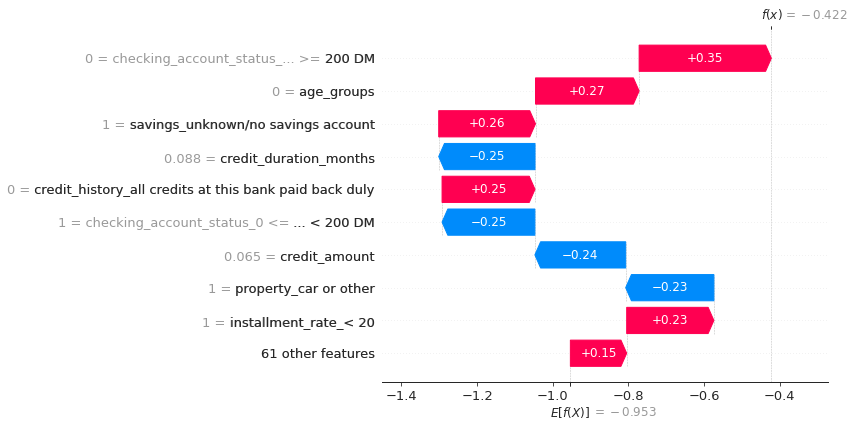

In [ ]:
# Set the style of plotting to white
sns.set_style("white")
# Load JS visualization code to notebook
shap.initjs()
# Create waterfall plot
shap.plots.waterfall(shap_values[2])


- The SHAP analysis reveals that the age feature has a significant positive contribution to the model's prediction of credit risk, with a SHAP value of +0.27. This indicates that older individuals are more likely to be classified as credit risks by the model.

<Figure size 720x360 with 0 Axes>

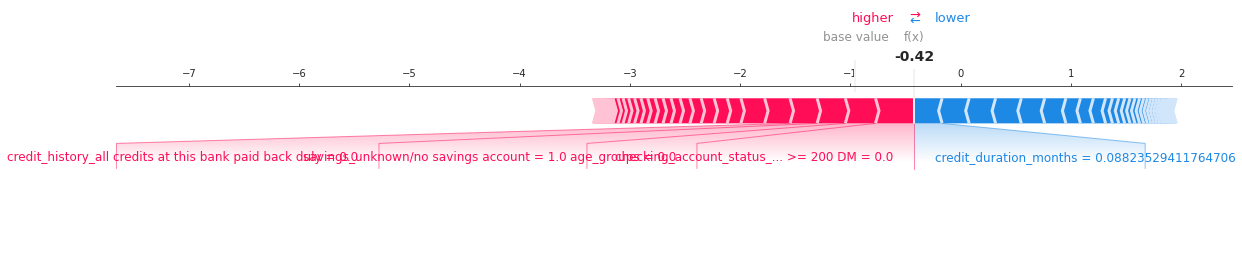

In [ ]:
datapoint_num = 2  # Needs to be between 0 and length of dataframe
plt.figure(figsize=(10, 5))
# Plot explanations
shap.force_plot(
    explainer.expected_value,
    shap_values[datapoint_num].values,
    X_sample.iloc[datapoint_num],
    matplotlib=True
)


- As the SHAP value for the age_groups feature is contributing 0.0, it means that this particular feature does not influence the model's prediction for that specific instance. In other words, the model considers the age_groups feature as neither positively nor negatively impacting the predicted outcome for this individual data point.

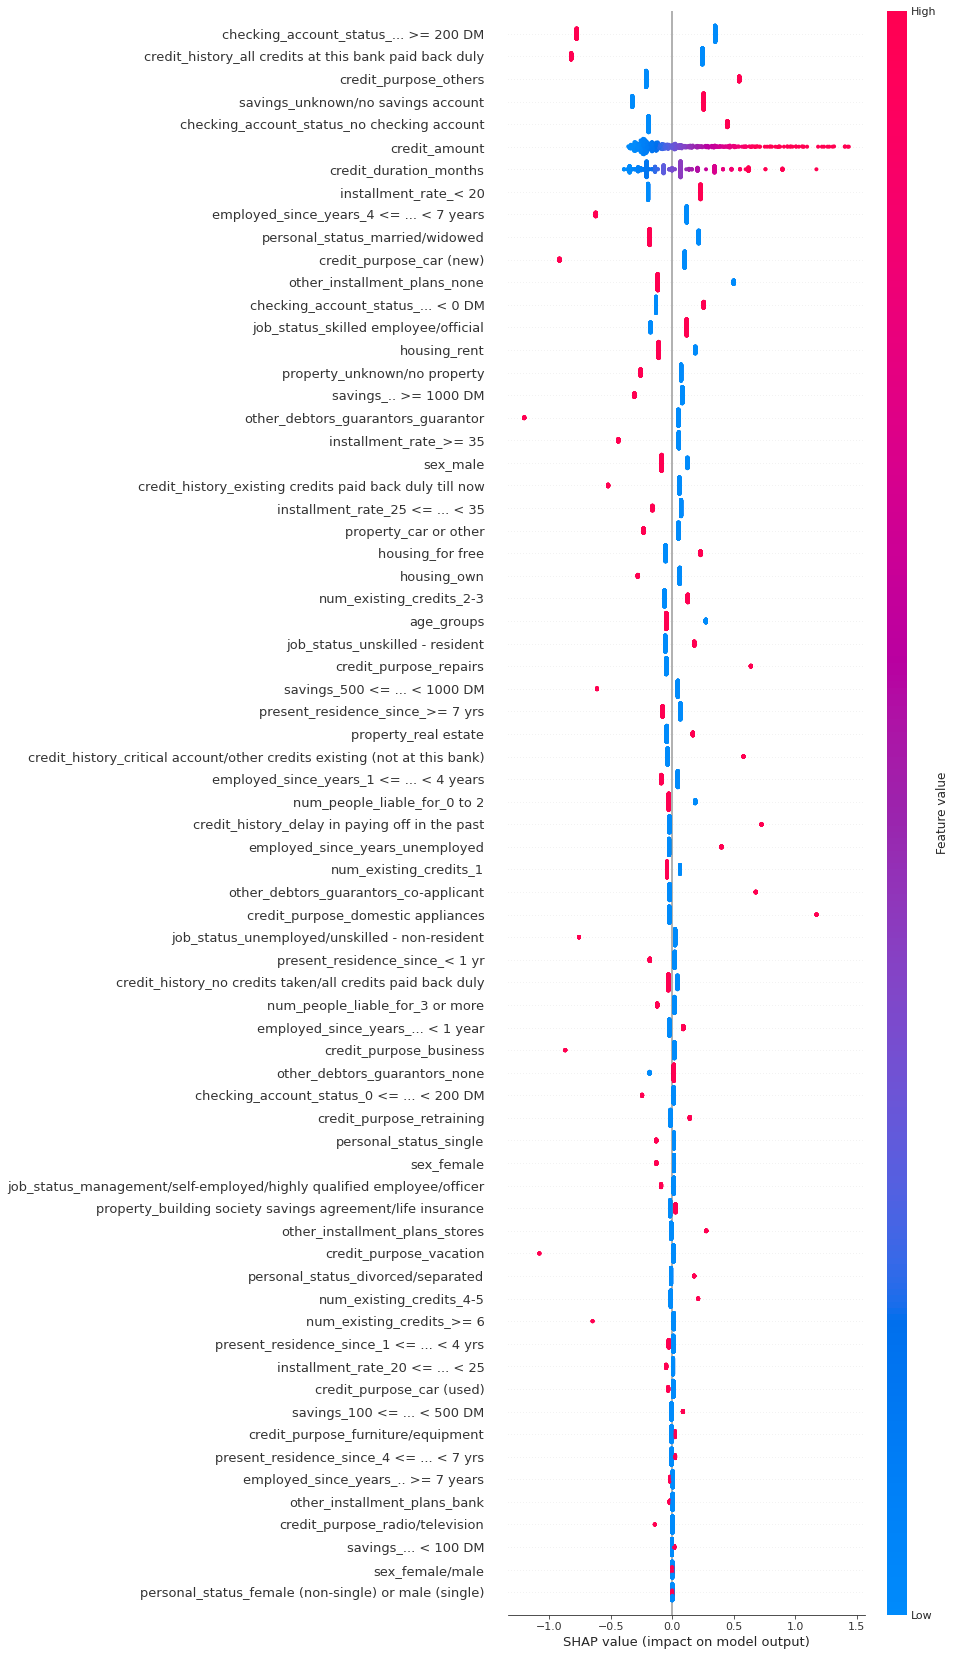

In [ ]:
shap.plots.beeswarm(shap_values[:, :], max_display=None)

- The SHAP beeswarm plot shows that age groups significantly impact the model's predictions for credit risk. The clear separation of blue and red dots indicates that certain age ranges are associated with a higher likelihood of positive outcomes (red) while others are linked to lower likelihoods (blue). The variability in the spread of dots suggests that the influence of age groups varies across different instances, highlighting their importance in assessing credit risk.

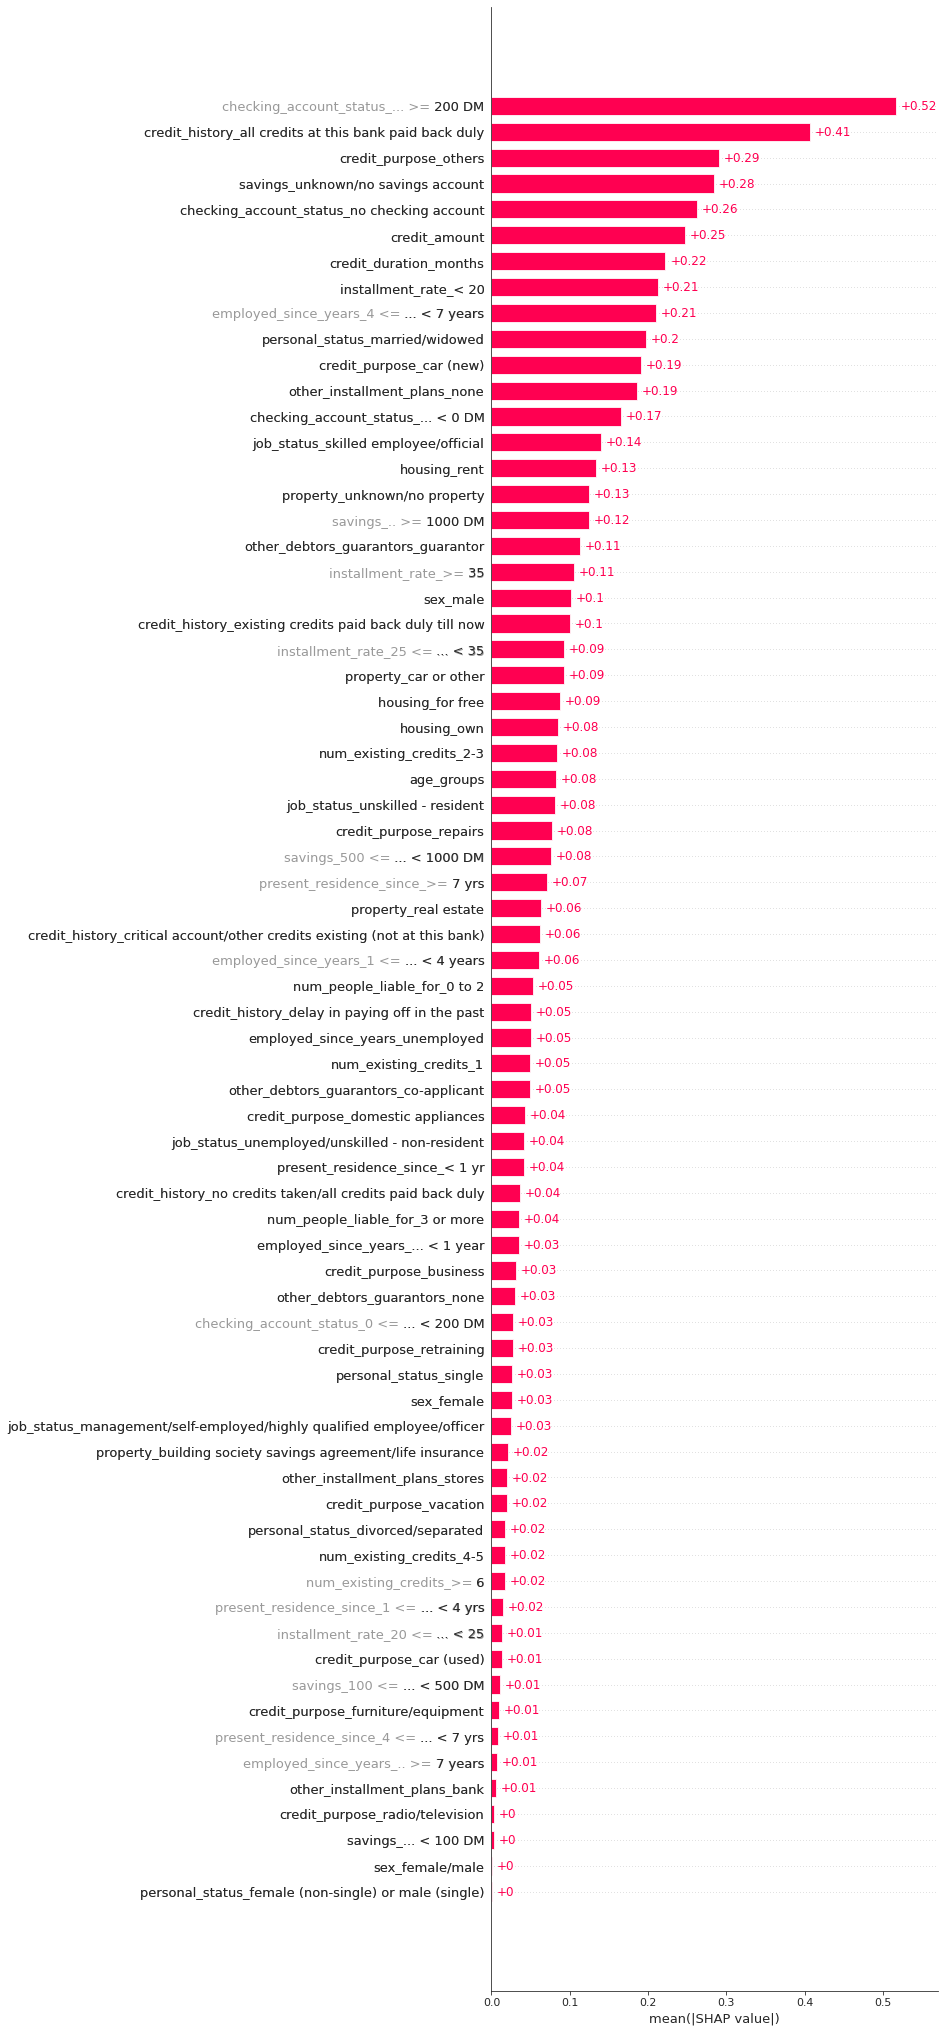

In [ ]:
shap.plots.bar(shap_values[:, :], max_display=None)


- The value of +0.08 indicates that the age groups generally contribute positively to the likelihood of a positive outcome (e.g., being classified as not a credit risk) in your credit risk model. This means that, as the shap values are positive for the older individuals, on average, older age groups are more likely to receive favorable predictions.

# Testing and Mitigating Disparate Impact with IBM AI Fairness 360 - pre processing technique

In this section, we will explore the application of IBM's AI Fairness 360 (AIF360) toolkit to assess and mitigate disparities in the German Credit dataset. Disparate impact occurs when a decision-making process leads to unfair disadvantages for certain demographic groups, often without any explicit intent to discriminate.

Using AIF360, we will systematically identify and evaluate the presence of bias in our dataset by measuring the disparate impact across protected attributes, such as age groups. We will implement techniques to preprocess our training and test data, apply DI impact remover to the dataset, and visualize the effects of these transformations. The ultimate goal is to develop a predictive model that not only performs well but also ensures fairness in its outcomes.

Throughout this analysis, we will focus on key fairness metrics, including the disparate impact ratio, accuracy, and F1 scores.

## Pre processing traning data for analyzing it using AIF360

In [ ]:
# Fit the dataprocessor to our training data
data_processor.fit(X_train)
ft_names = numerical_features + list(
    data_processor.transformers_[1][1]
    .named_steps["cat_encoder"]
    .get_feature_names_out(categorical_features)
)

# Add column names and convert to data frame
processed_train_df = pd.DataFrame(
    data_processor.transform(X_train).todense(), columns=ft_names
)

# Extract feature names from data processor (we need this as one-hot encoding creates new columns)
cat_ft_names = list(
    data_processor.transformers_[1][1]
    .named_steps["cat_encoder"]
    .get_feature_names_out(categorical_features)
)

# Join label with the transformed dataset so we can pass it to AIF360
train_df = pd.concat([processed_train_df, train_data[model_target]], axis=1)

## Creating a BinaryLabelDataset and checking the DI value of the training dataset without DI removal

In [ ]:
# Create a Dataset construct for AIF360
binaryLabelDataset_train = BinaryLabelDataset(
    df=train_df,
    label_names=["credit_risk"],
    protected_attribute_names=["age_groups"],
    favorable_label=0.0,
    unfavorable_label=1.0,
)

# Check pre-training bias
print(
    BinaryLabelDatasetMetric(
        binaryLabelDataset_train,
        unprivileged_groups=[{"age_groups": 0}],
        privileged_groups=[{"age_groups": 1}],
    ).disparate_impact()
)

0.8371212121212122


## Removing DI usig AIF360 DisparateImpactRemover

In [ ]:
# Initialize DisparateImpactRemover
di_remover = DisparateImpactRemover(repair_level=0.5)

# Create transformed version (DI removed)
binaryLabelDataset_transform_train = di_remover.fit_transform(binaryLabelDataset_train)

# Convert back to dataframe
df_transform_train_di_removed = binaryLabelDataset_transform_train.convert_to_dataframe()[0]

below we can see that that the transformation changed only the features, but not the labels. So the DI value is same for both now and previously

In [ ]:
# Check pre-training bias for transformed dataset
print(
    BinaryLabelDatasetMetric(
        binaryLabelDataset_transform_train,
        unprivileged_groups=[{"age_groups": 0}],
        privileged_groups=[{"age_groups": 1}],
    ).disparate_impact()
)

0.8371212121212122


## Visualization for checking the affect of DI removal on credit_amount

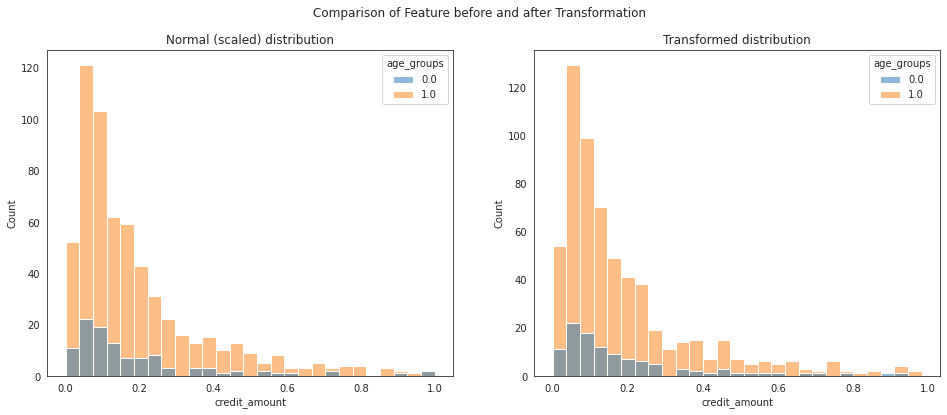

In [ ]:
%matplotlib inline

# CONVERTING FROM SPARSE TO DENSE TO AVOID ERRORS IN SNS
train_df_dense = train_df.apply(lambda x: x.sparse.to_dense() if pd.api.types.is_sparse(x) else x)
df_transform_train_dense = df_transform_train_di_removed.apply(lambda x: x.sparse.to_dense() if pd.api.types.is_sparse(x) else x)

# Initialize figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Set title of figure
fig.suptitle("Comparison of Feature before and after Transformation")

# Set title
ax1.title.set_text("Normal (scaled) distribution")
ax2.title.set_text("Transformed distribution")

# Create plots
sns.histplot(train_df_dense, x="credit_amount", hue="age_groups", ax=ax1)
sns.histplot(df_transform_train_dense, x="credit_amount", hue="age_groups", ax=ax2)
plt.show()

- The transformation to reduce disparate impact on the "credit_amount" variable shows some effect but not a complete balance. Before the transformation (left plot), the older age group (1.0) had a much higher count in lower credit amounts compared to the younger group (0.0). After the fairness adjustment (right plot), the distribution remains similar, but there is a slight improvement in balance, especially for lower credit amounts. However, the older age group still dominates, indicating that while the transformation helped, some disparity remains.

## Train a Logistic Regression Classifier on DI removed dataset

In [ ]:
# Training the model with disparate impact remover

# Get train data to train the classifier
X_train_transform = df_transform_train_di_removed.drop([model_target, "age_groups"], axis=1)
y_train = train_data[model_target]

# Initialize the LR
lr_di = LogisticRegression(solver="liblinear")

# Fit the classifier to the transformed data
di_model = lr_di.fit(X_train_transform, y_train.ravel())

## Applying DI removal for the test set

In [ ]:
# Convert the sparse matrix to a pandas dataframe and name columns

processed_test_df = pd.DataFrame(
    data_processor.transform(test_data[model_features]).todense(), columns=numerical_features + cat_ft_names
)

# Repeat for test data
processed_test_df_with_labels = pd.concat(
    [
        processed_test_df,
        pd.read_csv("data/german_credit_test_labels.csv")[
            "credit_risk"
        ],
    ],
    axis=1,
)

# Create a Dataset construct for AIF360
binaryLabelDataset_test = BinaryLabelDataset(
    df=processed_test_df_with_labels,
    label_names=["credit_risk"],
    protected_attribute_names=["age_groups"],
    favorable_label=0.0,
    unfavorable_label=1.0,
)

# Create transformed version (DI removed)
binaryLabelDataset_transform_test = di_remover.fit_transform(binaryLabelDataset_test)

# Convert back to dataframe
df_transform_test = binaryLabelDataset_transform_test.convert_to_dataframe()[0].drop(
    "credit_risk", axis=1
)

## Make Predictions on the Test Dataset

In [ ]:
# we use the processed weights for di during testing
X_test_di = df_transform_test.drop(["age_groups"], axis=1).copy(deep=True)
# Use the fitted model to make predictions on the test dataset
test_predictions_di = di_model.predict(X_test_di)

In [ ]:
# writing predictions into a file
result_df_di = pd.DataFrame(columns=["ID", "credit_risk_pred"])
result_df_di["ID"] = test_data["ID"].tolist()
#saving rw and di precidtions into csv for later use for calc f1 and accuracy
result_df_di["credit_risk_pred"] = test_predictions_di

result_df_di.to_csv("data/testing_results_di.csv", index=False)

## Evaluating Disparate Impact on Test Dataset

In [ ]:
di= calculate_di(test_data, result_df_di, "credit_risk_pred")
dict_metrics["di_removed_preprocessing"]["di"] = di
di

0.6028368794326241

## Accuracy and f1 scores

In [ ]:
acc_sc = accuracy_score(
    pd.read_csv("data/german_credit_test_labels.csv")[
        "credit_risk"
    ],
    result_df_di["credit_risk_pred"],
)
dict_metrics["di_removed_preprocessing"]["accuracy"] = acc_sc
acc_sc

0.77

In [ ]:
f1 = f1_score(
    pd.read_csv("data/german_credit_test_labels.csv")[
        "credit_risk"
    ],
    result_df_di["credit_risk_pred"],
)
dict_metrics["di_removed_preprocessing"]["f1"] = f1
f1


0.5576923076923077

# Reweighing - pre process technique
In this section, we will implement a reweighing technique to address the disparate impact in our dataset. Reweighing involves assigning different weights to the samples in the training data based on their sensitive attributes. This helps to ensure that the model treats different demographic groups more fairly during training. By adjusting the weights, we aim to mitigate the bias introduced by the original data distribution.


In [ ]:
# function to reweigh the data
def reweighing(data, label, sensitive_attr, return_list=True):
    label_dict = dict()
    try:
        # This will loop through the different labels (1 - awarded grant, 0 - not awarded)
        for outcome in data[label].unique():
            weight_map = dict()
            # Check for all possible groups (here we have A & B but there could be more in reality)
            for val in data[sensitive_attr].unique():
                # Calculate the probabilities
                nom = (
                    len(data[data[sensitive_attr] == val])
                    / len(data)
                    * len(data[data[label] == outcome])
                    / len(data)
                )
                denom = len(
                    data[(data[sensitive_attr] == val) & (data[label] == outcome)]
                ) / len(data)
                # Store weights according to sensitive attribute
                weight_map[val] = round(nom / denom, 2)
            # Store
            label_dict[outcome] = weight_map
        # Create full list of all weights for every data point provided as input
        data["weights"] = list(
            map(lambda x, y: label_dict[y][x], data[sensitive_attr], data[label])
        )
        if return_list == True:
            return data["weights"].to_list()
        else:
            return label_dict
    except Exception as err:
        print(err)
        print("Dataframe might have no entries.")

In [ ]:
reweigh_dict = reweighing(train_data, "credit_risk", "age_groups", False)


## Train a Classifier using reiweighied traning data

Train the LogisticRegression pipeline.

In [ ]:
# Training the model with re-weighting

# Get train data to train the classifier
X_train = processed_train_df.drop(["age_groups"], axis=1)
y_train = train_data[model_target]

# Fit the classifier to the train data
train_sample_weights = list(
    map(
        lambda x, y: reweigh_dict[y][x],
        train_df["age_groups"],
        train_df[model_target],
    )
)

# Initialize the LR
lr_rw = LogisticRegression(solver="liblinear")

# Make sure to add the sample weights
rw_model = lr_rw.fit(X_train, y_train.ravel(), sample_weight=train_sample_weights)

## Make Predictions on the Test Dataset

In [ ]:
# Get test data to validate the classifier
# use the original test
X_test = processed_test_df.drop(["age_groups"], axis=1).copy(deep=True)


# Use the fitted model to make predictions on the test dataset
test_predictions_rw = di_model.predict(X_test)


In [ ]:
# writing predicitons into a file
result_df_rw = pd.DataFrame(columns=["ID", "credit_risk_pred"])
result_df_rw["ID"] = test_data["ID"].tolist()
result_df_rw["credit_risk_pred"] = test_predictions_rw
result_df_rw.to_csv("data/testing_resuls_reweighing.csv", index=False)


## Evaluating Disparate Impact on Test Dataset


In [ ]:
di = calculate_di(test_data, result_df_rw, "credit_risk_pred")
dict_metrics["reweighing_preprocessing"]["di"] = di
di

0.6115107913669064

### Accuracy & F1 Score

In [ ]:
acc_sc = accuracy_score(
    pd.read_csv("data/german_credit_test_labels.csv")[
        "credit_risk"
    ],
    result_df_rw["credit_risk_pred"],
)
dict_metrics["reweighing_preprocessing"]["accuracy"] = acc_sc
acc_sc


0.78

In [ ]:
f1 = f1_score(
    pd.read_csv("data/german_credit_test_labels.csv")[
        "credit_risk"
    ],
    result_df_rw["credit_risk_pred"],
)
dict_metrics["reweighing_preprocessing"]["f1"] = f1
f1


0.5849056603773585

# Equlaized odds - post process technique
In this section, we implement the Equalized Odds (EO) post-processing technique to evaluate and mitigate bias in the predictions made by our model. Equalized Odds aims to ensure that the model's error rates are similar across different demographic groups, specifically concerning sensitive attributes like age.


In [ ]:
# removin the sensitive variable from the model features and dataframes
sensitive_feature = "age_groups"
eo_model_features = (numerical_features+categorical_features)[:]
eo_model_features.remove(sensitive_feature)
eo_numerical_features = numerical_features[:]
eo_categorical_features = categorical_features[:]
try:
    eo_numerical_features.remove(sensitive_feature)
except:
    pass

try:
    eo_categorical_features.remove(sensitive_feature)
except:
    pass

X_train_prep = processed_train_df.drop(sensitive_feature, axis=1)
X_test_prep = processed_test_df.drop(sensitive_feature, axis=1)

## Setting up ThresholdOptimizer for equalized odds

In [ ]:

# Set up ThresholdOptimizer for EO
eo_model = ThresholdOptimizer(
    estimator=pipeline[-1],
    constraints="equalized_odds",
    objective="accuracy_score",
    grid_size=1000,
    flip=False,
    prefit=False,
    predict_method="deprecated",
)

# fitting the data to the ThresholdOptimizer mentioning the sensitive feature
eo_model.fit(X_train_prep, y_train, sensitive_features=train_data[sensitive_feature].values)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LogisticRegression(penalty='none'))

## Make predicitons on test dataset using EO

In [ ]:
y_test_eo_adjusted = eo_model.predict(
    X_test_prep,
    sensitive_features=test_data[sensitive_feature].values,
)

## Pipeline for predicting without applying equalized odds

In [ ]:
# Preprocess the numerical features
numerical_processor = Pipeline(
    [("num_imputer", SimpleImputer(strategy="mean")), ("num_scaler", MinMaxScaler())]
)
# Preprocess the categorical features
categorical_processor = Pipeline(
    [
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("cat_encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)


# Combine all data preprocessors from above
data_processor = ColumnTransformer(
    [
        ("numerical_processing", numerical_processor, eo_numerical_features),
        ("categorical_processing", categorical_processor, eo_categorical_features),
    ]
)


pipeline_eo = Pipeline(
    [
        ("data_processing", data_processor),
        ("lg", LogisticRegression(random_state=0)),
    ]
)


set_config(display="diagram")
pipeline_eo


Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numerical_processing',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['credit_duration_months',
                                                   'credit_amount']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('cat_encoder',
                                                                   OneHot...))]),
                                                  ['sex', 'personal_status',
                                                   'checking_account_status',
                                                   'credit_history',
                                                   'credit_purpose', 'savings',
                                                   'employed_since_years',
                                                   'installment_rate',
                                                   'other_debtors_guarantors',
                                                   'present_residence_since',
                                                   'property',
                                                   'other_installment_plans',
                                                   'housing',
                                                   'num_existing_credits',
                                                   'job_status',
                                                   'num_people_liable_for'])])),
                ('lg', LogisticRegression(random_state=0))])

## Training Logistic regression without equalized odds for comparision

In [ ]:
pipeline_eo.fit(train_data[eo_model_features], train_data[model_target])
y_test_withoutEO = pipeline_eo.predict(test_data[eo_model_features])

## Find predictions with and without equalized odds

In [ ]:
# saving the predictions with EO into a file
result_df_eo = pd.DataFrame(columns=["ID", "credit_risk_pred"])
result_df_eo["ID"] = test_data["ID"].tolist()
result_df_eo["credit_risk_pred"] = y_test_eo_adjusted
result_df_eo.to_csv("data/testing_resuls_with_eo.csv", index=False)

# saving the predictions without EO into a file
result_df_no_eo = pd.DataFrame(columns=["ID", "credit_risk_pred"])
result_df_no_eo["ID"] = test_data["ID"].tolist()
result_df_no_eo["credit_risk_pred"] = y_test_withoutEO
result_df_no_eo.to_csv("data/testing_resuls_without_eo.csv", index=False)

## Plot for comparing the test data predicitons with and without applying EO

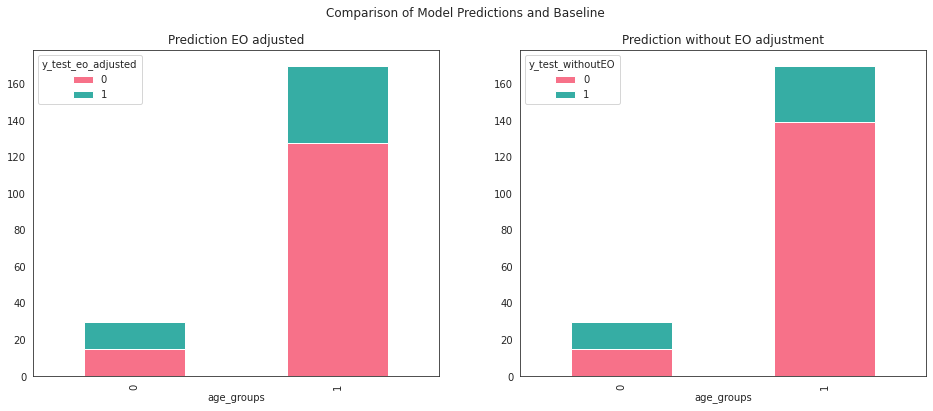

In [ ]:
# Join the data, adjusted predictions, original predictions
eo_df_test = pd.DataFrame(
    {
        "age_groups": test_data[sensitive_feature].reset_index(drop=True),
        "y_test_eo_adjusted": y_test_eo_adjusted,
        "y_test_withoutEO": y_test_withoutEO,
    }
)

%matplotlib inline
# Initialize figure
fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(16, 6))

# Set title of figure
fig.suptitle("Comparison of Model Predictions and Baseline")

# Set title
ax2.title.set_text("Prediction EO adjusted")
ax3.title.set_text("Prediction without EO adjustment")

# Create plots
eo_df_test.groupby([sensitive_feature, "y_test_eo_adjusted"]).size().unstack().plot(
    kind="bar", stacked=True, color=sns.husl_palette(2), ax=ax2
)
eo_df_test.groupby([sensitive_feature, "y_test_withoutEO"]).size().unstack().plot(
    kind="bar", stacked=True, color=sns.husl_palette(2), ax=ax3
)
# Align y-axis
ax3.sharey(ax2)


- The Equalized Odds (EO) technique improved fairness by balancing the model’s predictions across age groups. In the adjusted model (left plot), the predictions for age group 1 are more evenly distributed between classes 0 and 1, while the unadjusted model (right plot) shows a strong bias towards class 0 for the same group. This indicates that EO successfully reduced prediction bias, making the model fairer across different age groups.

## Evaluating Disparate Impact on Test Data


In [ ]:
di = calculate_di(test_data, result_df_eo, "credit_risk_pred")
print("with EO-->",di)
print("without EO-->",calculate_di(test_data, result_df_no_eo, "credit_risk_pred"))
dict_metrics["equalized_odds_preprocessing"]["di"] = di

with EO--> 0.6640625
without EO--> 0.6115107913669064


## Accuracy & F1 Score

#### with EO

In [ ]:
acc_sc = accuracy_score(
    pd.read_csv("data/german_credit_test_labels.csv")[
        "credit_risk"
    ],
    result_df_eo["credit_risk_pred"],
)
dict_metrics["equalized_odds_preprocessing"]["accuracy"] = acc_sc
acc_sc

0.705

In [ ]:
f1 = f1_score(
    pd.read_csv("data/german_credit_test_labels.csv")[
        "credit_risk"
    ],
    result_df_eo["credit_risk_pred"],
)
dict_metrics["equalized_odds_preprocessing"]["f1"] = f1
f1

0.4957264957264957

#### without EO

In [ ]:
accuracy_score(
    pd.read_csv("data/german_credit_test_labels.csv")[
        "credit_risk"
    ],
    result_df_no_eo["credit_risk_pred"],
)

0.78

In [ ]:
f1_score(
    pd.read_csv("data/german_credit_test_labels.csv")[
        "credit_risk"
    ],
    result_df_no_eo["credit_risk_pred"],
)

0.5849056603773585

In [ ]:
###########################################################################################################################
###########################################################################################################################

# Evaluation of Fairness Metrics

Impact of various fairness preprocessing techniques on model performance metrics taking credit_risk as the output and the sensitive variable as age_groups, specifically focusing on the Disparate Impact (DI), accuracy, and F1 score.

## Metrics Overview

We have the following metrics for different preprocessing techniques:
<table>
    <tr>
        <th>Preprocessing Technique</th>
        <th>Disparate Impact (DI)</th>
        <th>Accuracy</th>
        <th>F1 Score</th>
    </tr>
    <tr>
        <td>No Preprocessing</td>
        <td>0.458</td>
        <td>0.785</td>
        <td>0.619</td>
    </tr>
    <tr>
        <td>DI Removed (using AIF360)</td>
        <td>0.603</td>
        <td>0.770</td>
        <td>0.558</td>
    </tr>
    <tr>
        <td>Reweighing (using Fairlearn)</td>
        <td>0.612</td>
        <td>0.780</td>
        <td>0.585</td>
    </tr>
    <tr>
        <td>Equalized Odds (using Fairlearn)</td>
        <td>0.685</td>
        <td>0.705</td>
        <td>0.512</td>
    </tr>
</table>


### Analysis of Results

1. **No Preprocessing**:
    - The baseline model shows a DI of 0.458(<0.8), indicating a potential disparity in outcomes across groups. The accuracy is relatively high at 0.785, with a reasonable F1 score of 0.619.

2. **DI Removed (using AIF360)**:
    - This approach results in an improved DI of 0.603, indicating reduced disparity. However, the accuracy slightly decreases to 0.770, and the F1 score drops to 0.558.

3. **Reweighing (using Fairlearn)**:
    - With reweighing, the DI improves to 0.612, with accuracy remaining steady at 0.780 and a slight increase in F1 score to 0.585. This suggests a balanced approach between fairness and predictive performance.

4. **Equalized Odds (using Fairlearn)**:
    - The equalized odds method achieves the best DI at 0.685, indicating a further reduction in disparity. However, this comes at the cost of a significant drop in accuracy to 0.705 and a decrease in F1 score to 0.512.


References:
- https://www.trustworthyml.org/resources
- https://towardsdatascience.com/approaches-for-addressing-unfairness-in-machine-learning-a31f9807cf31
- https://www.youtube.com/watch?v=utRsidz8TJM
- https://towardsdatascience.com/analysing-fairness-in-machine-learning-with-python-96a9ab0d0705
- https://medium.com/@nimritakoul01/explainable-ai-with-shap-544560318b60
- https://www.youtube.com/watch?v=-2N6V8B3Shw&t=1368s
